# **Importing libraries**

In [150]:
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D,MaxPool2D
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import to_categorical
import cv2,os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import time

from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/face_recognition/project

%matplotlib inline

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/face_recognition/project


## **Data Preprocessing**


In [151]:
data_path='data'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]
label_dict =dict(zip(categories,labels))
print(label_dict)
print(categories)
print(labels)

{'with_mask': 0, 'without_mask': 1}
['with_mask', 'without_mask']
[0, 1]


In [152]:
img_size=100
data=[]
target=[]

for category in categories:
  folder_path=os.path.join(data_path,category)
  img_names=os.listdir(folder_path)
  
  
  for img_name in img_names:
    img_path=os.path.join(folder_path,img_name)
    img=cv2.imread(img_path)
    
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      #converting the img ijto grayscale
    resized=cv2.resize(gray,(img_size,img_size),interpolation=cv2.INTER_CUBIC)
      #reshaping the grayscale img into 100*100,since we need a fix common size for all the size
    data.append(resized)
    if label_dict[category]==0:
        target.append([0])
    else:
        target.append([1])
X,Y=shuffle(data,target)

data=np.array(X)
target=np.array(Y)

print(data.shape)
print(target.shape)

(1376, 100, 100, 3)
(1376, 1)


#**Loading data**

In [153]:
def plot_images(X,Y,n=50):
  # n is number of examples to plot
  for labels in [0,1]:
    images = X[np.argwhere(Y == labels)]
    n_images = images[:n]
    columns_n=10
    rows_n=int(n/columns_n)
    plt.figure(figsize=(20,10))
    i=1 # current plot
    for image in n_images:
        plt.subplot(rows_n, columns_n, i)
        plt.imshow(image[0])
        # remove ticks
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        i += 1
    label_to_str = lambda label: "No" if label == 1 else "Yes"
    plt.suptitle(f"face mask: {label_to_str(labels)}")
    plt.show()


In [154]:
plot_images(data,target)
target = to_categorical(target, num_classes=2)
print(target.shape)

Output hidden; open in https://colab.research.google.com to view.

#**Splitting data into training, cross-validation and test set**

In [155]:
def split_data(X, Y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        Y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, Y_train, Y_test_val = train_test_split(X, Y, test_size=test_size)
    X_test, X_val, Y_test, Y_val = train_test_split(X_test_val, Y_test_val, test_size=0.5)
    
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [156]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data(data,target, test_size=0.3)

In [157]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 963
number of development examples = 207
number of test examples = 206
X_train shape: (963, 100, 100, 3)
Y_train shape: (963, 2)
X_val (dev) shape: (207, 100, 100, 3)
Y_val (dev) shape: (207, 2)
X_test shape: (206, 100, 100, 3)
Y_test shape: (206, 2)


In [158]:
#nicely formatted time string
def  hms_string(sec_elapsed):
  h=int(sec_elapsed/(60*60))
  m=int((sec_elapsed%(60*60))/60)
  s=sec_elapsed%60
  return f"{h}:{m}:{round(s,1)}"


# **Model**
###Using a transfer learning (InceptionV3) model from keras

In [159]:
pre_trained_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(100, 100, 3))
pre_trained_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_385 (Conv2D)             (None, 49, 49, 32)   864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 49, 49, 32)   96          conv2d_385[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 49, 49, 32)   0           batch_normalization_376[0][0]    
_______________________________________________________________________________________

In [160]:
'''
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
'''
for layer in pre_trained_model.layers:
    layer.trainable = False
    
last_layer = pre_trained_model.get_layer('mixed7')
print('Last layer output shape :', last_layer.output_shape)
last_output = last_layer.output

Last layer output shape : (None, 4, 4, 768)


In [161]:

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
#The Final layer with 3 outputs for 3 categories
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.models.Model(inputs=pre_trained_model.input, outputs=x)

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_385 (Conv2D)             (None, 49, 49, 32)   864         input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 49, 49, 32)   96          conv2d_385[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 49, 49, 32)   0           batch_normalization_376[0][0]    
____________________________________________________________________________________________

In [162]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [163]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='inception/model-{epoch:03d}.ckpt',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True, 
    verbose=0)
start_time = time.time()
incep = model.fit(X_train, 
                    Y_train, 
                    epochs=20, 
                    callbacks=[checkpoint], 
                    validation_data=(X_val, Y_val))
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/20
31/31 [==============================] - 21s 590ms/step - loss: 205.4604 - acc: 0.6203 - val_loss: 3.8409 - val_acc: 0.8889
Epoch 2/20
31/31 [==============================] - 18s 577ms/step - loss: 3.9161 - acc: 0.8877 - val_loss: 0.4787 - val_acc: 0.9469
Epoch 3/20
31/31 [==============================] - 17s 566ms/step - loss: 0.6054 - acc: 0.9246 - val_loss: 0.2010 - val_acc: 0.9614
Epoch 4/20
31/31 [==============================] - 17s 565ms/step - loss: 0.3393 - acc: 0.9282 - val_loss: 0.1394 - val_acc: 0.9565
Epoch 5/20
31/31 [==============================] - 17s 565ms/step - loss: 0.2244 - acc: 0.9269 - val_loss: 0.1178 - val_acc: 0.9420
Epoch 6/20
31/31 [==============================] - 21s 677ms/step - loss: 0.1303 - acc: 0.9512 - val_loss: 0.1131 - val_acc: 0.9614
Epoch 7/20
31/31 [==============================] - 17s 565ms/step - loss: 0.1304 - acc: 0.9514 - val_loss: 0.0704 - val_acc: 0.9758
Epoch 8/20
31/31 [==============================] - 17s 565ms/step 

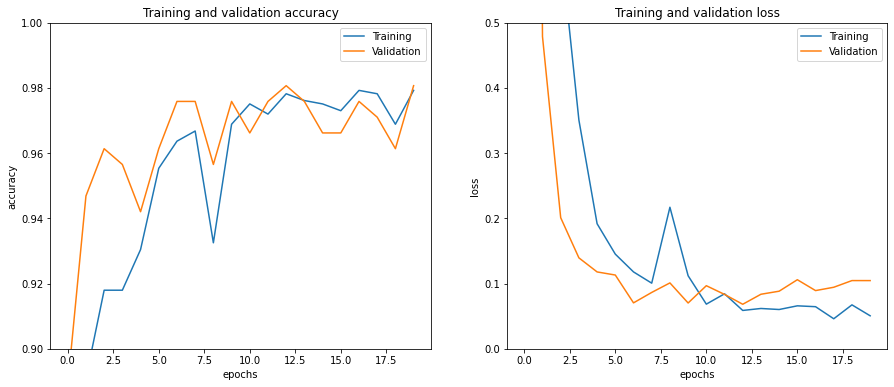

In [180]:
 #PLOT LOSS AND ACCURACY
acc = incep.history['acc']
val_acc = incep.history['val_acc']
loss = incep.history['loss']
val_loss = incep.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim([.9,1])
plt.legend()

plt.subplot(122)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim([0,0.5])
plt.legend()
plt.show()

In [165]:
model.save('inception/inceptionV3-model.h5')

In [166]:
loss,acc=model.evaluate(X_test, Y_test)

7/7 [==============================] - 3s 395ms/step - loss: 0.1795 - acc: 0.9320


In [167]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.1794693022966385
Test Accuracy = 0.9320388436317444


# **with our own model**


In [168]:

def my_model():
  inputs=keras.Input((100,100,3))
  x=Conv2D(90,(3,3))(inputs)
  x=keras.activations.relu(x)
  #x=MaxPool2D()(x)
  x=tf.keras.layers.MaxPooling2D(2,2)(x)
  #The first CNN layer followed by Relu and MaxPooling layers

  x=Conv2D(70,3)(x)
  x=keras.activations.relu(x)
  #x=MaxPool2D()(x)
  x=tf.keras.layers.MaxPooling2D(2,2)(x)
  #The second convolution layer followed by Relu and MaxPooling layers

  x=Flatten()(x)
  x=Dropout(0.5)(x)
  ##Flatten layer to stack the output convolutions from second convolution layer

  x=Dense(50,activation='relu')(x)
  #Dense layer of 64 neurons

  outputs=Dense(2,activation="softmax")(x)
  #The Final layer with two outputs for two categories
  model=keras.Model(inputs=inputs,outputs=outputs)

  return model

In [169]:
model=my_model()

In [170]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [171]:

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='our_own_model/model-{epoch:03d}.ckpt',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True, 
    verbose=0)
start_time = time.time()
our_model = model.fit(X_train, 
                    Y_train, 
                    epochs=20, 
                    callbacks=[checkpoint], 
                    validation_data=(X_val, Y_val))
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/20
31/31 [==============================] - 33s 1s/step - loss: 103.9725 - accuracy: 0.5214 - val_loss: 0.5134 - val_accuracy: 0.7874
Epoch 2/20
31/31 [==============================] - 32s 1s/step - loss: 0.5040 - accuracy: 0.7673 - val_loss: 0.2956 - val_accuracy: 0.8696
Epoch 3/20
31/31 [==============================] - 32s 1s/step - loss: 0.2597 - accuracy: 0.8903 - val_loss: 0.2053 - val_accuracy: 0.9275
Epoch 4/20
31/31 [==============================] - 32s 1s/step - loss: 0.1685 - accuracy: 0.9357 - val_loss: 0.1288 - val_accuracy: 0.9469
Epoch 5/20
31/31 [==============================] - 32s 1s/step - loss: 0.1065 - accuracy: 0.9624 - val_loss: 0.1084 - val_accuracy: 0.9517
Epoch 6/20
31/31 [==============================] - 32s 1s/step - loss: 0.1086 - accuracy: 0.9667 - val_loss: 0.1019 - val_accuracy: 0.9614
Epoch 7/20
31/31 [==============================] - 32s 1s/step - loss: 0.0609 - accuracy: 0.9808 - val_loss: 0.0985 - val_accuracy: 0.9662
Epoch 8/20
31/31 [

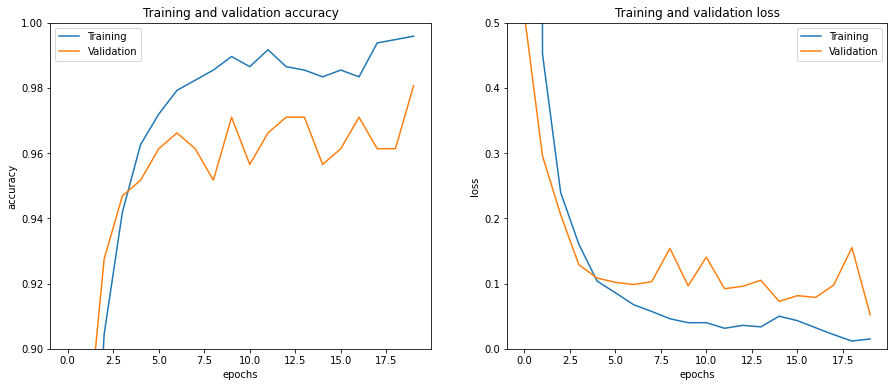

In [179]:
acc = our_model.history['accuracy']
val_acc = our_model.history['val_accuracy']
loss = our_model.history['loss']
val_loss = our_model.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim([.9,1])
plt.legend()

plt.subplot(122)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim([0, 0.5])
plt.legend()
plt.show()

In [173]:
model.save('our_own_model/OwnModel-model.h5')

In [174]:
loss, acc =model.evaluate(x=X_test, y=Y_test)

7/7 [==============================] - 2s 242ms/step - loss: 0.0709 - accuracy: 0.9709


In [175]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.07088583707809448
Test Accuracy = 0.9708737730979919
